# Identifying Yoga Poses

We've collected a few samples for each pose we'd like to categorize, and we need to learn how to identify which pose the user is in. We first used our tflite convolutional pose machine model to obtain a graphical representation of the poses we collected. This will produce a 28 point array of the various body part coordinates in each sample. We'll save this array along with its correct pose label to construct a dataset. First, let's import all the libraries we'll be using.

In [1]:
%matplotlib inline

import pickle
import multiprocessing
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
!pip install xgboost

Let's load our data and take a peak at what those samples look like.

Format the data so we can feed it to a model.

In [3]:
dataset = pd.read_csv('poses_standard.csv', header = None )#(index_col=0)
dataset

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,43,2021-06-0311:43:27.736508,290,238,305,218,270,220,322,227,...,0,0,0,0,0,0,0,0,0,wave_2hand
1,44,2021-06-0311:43:27.805804,289,238,304,219,268,219,321,227,...,0,0,0,0,0,0,0,0,0,wave_2hand
2,45,2021-06-0311:43:27.870116,289,238,304,218,268,220,321,227,...,0,0,0,0,0,0,0,0,0,wave_2hand
3,46,2021-06-0311:43:27.934738,290,237,305,218,268,221,321,226,...,480,0,0,0,0,0,0,0,0,wave_2hand
4,47,2021-06-0311:43:27.999255,290,237,304,218,270,220,321,227,...,0,0,0,0,0,0,0,0,0,wave_2hand
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1851,396,2021-03-0407:50:39.658752,352,112,357,106,345,106,367,111,...,241,375,300,340,304,373,357,344,356,standing
1852,397,2021-03-0407:50:39.822464,355,110,362,104,349,103,371,110,...,241,376,300,343,302,370,358,348,357,standing
1853,398,2021-03-0407:50:39.988838,358,110,365,104,352,104,373,109,...,242,379,301,342,303,374,359,346,356,standing
1854,399,2021-03-0407:50:40.155831,359,110,366,104,353,103,374,108,...,243,378,300,343,302,374,359,346,356,standing


In [4]:
# Spliting the points and the labels
#with file poses_standard.csv 36 column
#X = dataset.iloc[:, 2:-1].values  
#y = dataset.iloc[:, 36].values
#with file poses 38 column
X = dataset.iloc[:, 2:-1].values  
y = dataset.iloc[:, 36].values
X,y

(array([[290, 238, 305, ...,   0,   0,   0],
        [289, 238, 304, ...,   0,   0,   0],
        [289, 238, 304, ...,   0,   0,   0],
        ...,
        [358, 110, 365, ..., 359, 346, 356],
        [359, 110, 366, ..., 359, 346, 356],
        [358, 109, 365, ..., 359, 345, 357]]),
 array(['wave_2hand', 'wave_2hand', 'wave_2hand', ..., 'standing',
        'standing', 'standing'], dtype=object))

In [5]:
# And split the data into appropriate data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10) 
X_test
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((1670, 34), (1670,), (186, 34), (186,))

In [6]:
class_names = list(set(y))
num_class = len(class_names)
cores = multiprocessing.cpu_count()
num_class

3

Our data is ready to feed it to a model! Our first approach will be to classify which pose the user is currently in. If the user is not in the correct pose, we'll give them some advice on how to execute it. As we progress, we'll want to think about how to evaluate the user's pose, ie. how well are they execuring the pose. But for now, let's just determine if a user is in the right pose.

We'll try XGBoost. This algorithm is an implementation of gradient boosted decision trees. It ensembles many decision trees into one model - making it more accurate as a collection of trees.

XGBoost is very fast and it has more parameters to tune to improve the model. Feel free to pay with the learning_rate, n_estimators, etc to get better results. Also keep in mind that more data never hurts.

In [7]:
clf = XGBClassifier(max_depth=6, 
                    learning_rate=0.01, 
                    n_estimators=500, 
                    objective='multi:softmax', 
                    n_jobs=cores, 
                    num_class=num_class)

In [8]:
from sklearn.metrics import accuracy_score

model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [value for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)

/home/tommy/anaconda3/envs/demo/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:14:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [9]:
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
predictions = [value for value in preds]
predictions

/home/tommy/anaconda3/envs/demo/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:14:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


['wave_2hand',
 'wave_2hand',
 'standing',
 'standing',
 'up_down',
 'up_down',
 'standing',
 'wave_2hand',
 'wave_2hand',
 'wave_2hand',
 'wave_2hand',
 'wave_2hand',
 'up_down',
 'up_down',
 'wave_2hand',
 'wave_2hand',
 'wave_2hand',
 'wave_2hand',
 'wave_2hand',
 'up_down',
 'standing',
 'standing',
 'wave_2hand',
 'up_down',
 'standing',
 'up_down',
 'wave_2hand',
 'wave_2hand',
 'standing',
 'standing',
 'standing',
 'wave_2hand',
 'wave_2hand',
 'wave_2hand',
 'wave_2hand',
 'standing',
 'wave_2hand',
 'up_down',
 'standing',
 'wave_2hand',
 'wave_2hand',
 'up_down',
 'standing',
 'wave_2hand',
 'wave_2hand',
 'wave_2hand',
 'wave_2hand',
 'standing',
 'wave_2hand',
 'wave_2hand',
 'standing',
 'wave_2hand',
 'wave_2hand',
 'standing',
 'wave_2hand',
 'wave_2hand',
 'standing',
 'wave_2hand',
 'wave_2hand',
 'wave_2hand',
 'standing',
 'wave_2hand',
 'up_down',
 'wave_2hand',
 'up_down',
 'wave_2hand',
 'wave_2hand',
 'up_down',
 'standing',
 'standing',
 'wave_2hand',
 'wave_2h

We can see how well the model is grouping samples by printing the confusion matrix of the model. The confusion matrix will show us how often the model gets confused about a sample and misclassifies it AND to what it misclassifies.

We'll also look at the classification report which will give us the recall and precision among other stats for each label

In [10]:
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(y_test, preds)
print(conf_matrix)

class_report = classification_report(y_test, preds)
print(class_report)

[[ 43   0   1]
 [  0  28   0]
 [  0   0 114]]
              precision    recall  f1-score   support

    standing       1.00      0.98      0.99        44
     up_down       1.00      1.00      1.00        28
  wave_2hand       0.99      1.00      1.00       114

    accuracy                           0.99       186
   macro avg       1.00      0.99      0.99       186
weighted avg       0.99      0.99      0.99       186



In [11]:
preds = clf.predict(X_test[[0]])
predictions = [value for value in preds]
predictions

['wave_2hand']

And to get a better view let's graph the confusion matrix.

In [12]:
import itertools
from sklearn.metrics import plot_confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, rotation=45)
    plt.yticks(tick_marks)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

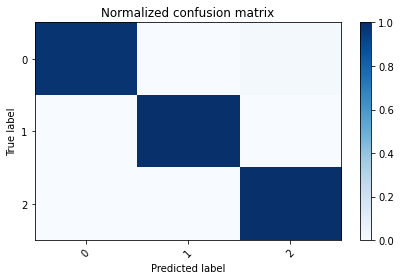

Classes:  ['standing', 'up_down', 'wave_2hand']


In [13]:
plot_confusion_matrix(conf_matrix, classes=sorted(class_names), normalize=True,
                      title='Normalized confusion matrix')
plt.show()
print('Classes: ', sorted(class_names))

Dark blue on the diagonal is what we're aiming for. We can see the model is really good at predicting tree_pose but warrior_1 gets confused with crescent_lunge and warrior_3 poses. However, this is a great start classifying a handful of distinct poses. We want to save the model to file so we can run inference while our virtual instructor is running.

In [14]:
filename = '../models/yoga_poses_wave.sav'
pickle.dump(clf, open(filename, 'wb'))

In [15]:
xgb_model_loaded = pickle.load(open(filename, "rb"))

In [16]:
preds = xgb_model_loaded.predict(X_test[[0]])
predictions = [value for value in preds]

In [17]:
predictions

['wave_2hand']

In [18]:
X_test[[0]]

array([[301, 110, 308, 105, 294, 104, 315, 109, 281, 106, 326, 148, 259,
        140, 364, 151, 219, 133, 364, 108, 222,  92, 306, 246, 262, 245,
        307, 326, 247, 320, 304, 391, 239, 384]])

In [19]:
abc = np.array([[318, 115 ,  325, 109 ,  311, 108 ,  333, 112 ,  301, 110 ,  345, 155 ,  282, 149 ,  351, 206 ,  265, 194 ,  342, 245 ,  267, 238 ,  321, 254 ,  285, 252 ,  313, 322 ,  279, 323 ,  300, 382 ,  276, 383]])
abc

array([[318, 115, 325, 109, 311, 108, 333, 112, 301, 110, 345, 155, 282,
        149, 351, 206, 265, 194, 342, 245, 267, 238, 321, 254, 285, 252,
        313, 322, 279, 323, 300, 382, 276, 383]])

In [20]:
preds = xgb_model_loaded.predict(abc)
preds

array(['wave_2hand'], dtype=object)